# SVM Classifier

In [24]:
import numpy as np

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import platform

# Import matplotlib libraries
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import time

In [25]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is /Users/lorenzobarbiero/Documents/GitHub/human_pose
data directory is /Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition


### Load the data

In [26]:
file_name = "movenet_thunder_mobilenet_large"

#choose from 
#'movenet_lightning_mobilenet_small'
#'movenet_lightning_mobilenet_large'
#'movenet_thunder_mobilenet_small'
#'movenet_thunder_mobilenet_large'

In [27]:
df = pd.read_pickle(data_directory + '/' + file_name + '.pkl')

# apply the function to the dataframe
df['keypoints'] = df['keypoints'].apply(lambda x: np.array(x))
df['object'] = df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
df['obj_vector'] = df['obj_vector'].apply(lambda x: np.array(x))
df['category'] = df['category'].apply(lambda x: np.array(x))

df['obj_input'] = df.apply(lambda x: np.sum(x['object']*x['obj_vector'], axis=0), axis=1)
df['keypoints'] = df['keypoints'].apply(lambda x: x.flatten())

df

,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words,obj_input
0,Image_1.jpg,sitting,11,"[0.0882076621055603, 0.6247615814208984, 0.756...","[[0.60480165], [0.04718776], [0.032203343], [0...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo...","[-0.20592125285495, 0.3260203410991888, -0.008..."
1,Image_2.jpg,using_laptop,14,"[0.30178800225257874, 0.9912914037704468, 0.80...","[[0.7418762], [0.040941585], [0.012892539], [0...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ...","[0.2683790374652541, -0.6670002713657828, 0.87..."
2,Image_3.jpg,hugging,7,"[0.20708897709846497, 0.6019015908241272, 0.42...","[[0.1416007], [0.13604547], [0.05453948], [0.0...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape...","[-0.02030288063444885, 0.23200371996866265, 0...."
3,Image_4.jpg,sleeping,12,"[0.37268558144569397, 0.1374012678861618, 0.20...","[[0.6505104], [0.06191667], [0.027490702], [0....","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia...","[-0.8215984234954313, -0.02994576481942718, -0..."
4,Image_5.jpg,using_laptop,14,"[0.03276867792010307, 0.2222181260585785, 0.79...","[[0.71057284], [0.10088889], [0.035408325], [0...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto...","[-0.1494515264241883, -0.1284101833971808, -0...."
...,...,...,...,...,...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[0.04209192469716072, 0.7099579572677612, 0.58...","[[0.23895389], [0.14317973], [0.076097175], [0...","[706, 905, 624, 559, 831]","[[-0.399260014295578, 0.13120000064373016, -0....","[[patio], [window, shade], [library], [folding...","[-0.14739882579379793, 0.2794763101199509, -0...."
12596,Image_12597.jpg,clapping,1,"[0.06415694206953049, 0.705790638923645, 0.468...","[[0.8603377], [0.021510318], [0.016789775], [0...","[617, 823, 678, 904, 905]","[[0.10435998439788818, 0.29162999987602234, 0....","[[lab, coat], [stethoscope], [neck, brace], [w...","[0.057619909586660134, 0.26067134955875726, 0...."
12597,Image_12598.jpg,sitting,11,"[0.051420778036117554, 0.4904737174510956, 0.5...","[[0.48068434], [0.07919033], [0.043129846], [0...","[608, 743, 843, 487, 543]","[[-0.13323000073432922, -0.6275100111961365, -...","[[jean], [prison], [swing], [cellular, telepho...","[-0.001942008389194727, -0.2787240437545768, -..."
12598,Image_12599.jpg,dancing,3,"[0.2283279001712799, 0.42992380261421204, 0.62...","[[0.15199172], [0.068358354], [0.059058633], [...","[416, 615, 747, 617, 587]","[[0.5044400095939636, 0.536300003528595, -0.07...","[[balance, beam], [knee, pad], [punching, bag]...","[0.014005273690095521, 0.06621338508228547, -0..."


### Create Datasets

In [28]:
def train_test_split_df(df, test_perc): 
    
    n_classes = df['category'].nunique()
    
    n_samples = int(len(df)*test_perc/n_classes)
    
    test_df = df.groupby('category').apply(lambda x: x.sample(n_samples, random_state=420)).reset_index(drop=True)

    # split the dataframe in train and test by the column 'filename'

    train_df = df[~df['filename'].isin(test_df['filename'])]
    
    return train_df, test_df

In [29]:
train_df, test_df = train_test_split_df(df, 0.2)

In [30]:
def create_dataset(df, use_object=True, use_kpoints=True):
    
    if use_object and use_kpoints:
        df['input'] = df.apply(lambda x: np.concatenate((x['keypoints'], x['obj_input'])), axis=1)
        data = np.zeros((len(df), 17*3+100))
    
    elif use_kpoints:
        df['input'] = df['keypoints']
        data = np.zeros((len(df), 17*3))
        
    elif use_object:
        df['input'] = df['obj_input']
        data = np.zeros((len(df), 100))
    
    else:
        print('error - select at least one feature')
        return -1, -1
    
    for i, row in enumerate(df['input']): 
        data[i,:] = np.array(row)
        
    labels = df['category']

    return data, labels

### GridSearch
Commented by deafult, run at your own risk

In [8]:
'''
kernel = ['rbf']
C = [1, 10, 100]
n_splits = 5

for kr in kernel:
    for c in C:
        print("Fitting SVM")
        print("Kernel", kr)
        print("C", c)
        
        # KFold cross-validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        accuracy_per_fold = []

        for train_index, val_index in kf.split(df):
    
            df_train, df_val = df.iloc[train_index], df.iloc[val_index]
    
            # Convert to TensorFlow datasets
            train_dataset, train_labels = create_dataset(df_train)
            val_dataset, val_labels = create_dataset(df_val)
    
            # Create a new instance of the model
            model = SVC(kernel=kr, C=c)

            # Train the model
            results = model.fit(train_dataset, train_labels)
    
            # compute predicted labels
            predicted_labels = model.predict(val_dataset)
    
            # Evaluate the model
            val_accuracy = accuracy_score(val_labels, predicted_labels)
            accuracy_per_fold.append(val_accuracy)
        
        print("Average accuracy:", np.round(np.mean(accuracy_per_fold),3), "±", np.round(np.std(accuracy_per_fold),3))
        print("---------------------------------------------------------")
        
'''

'\nkernel = [\'rbf\']\nC = [1, 10, 100]\nn_splits = 5\n\nfor kr in kernel:\n    for c in C:\n        print("Fitting SVM")\n        print("Kernel", kr)\n        print("C", c)\n        \n        # KFold cross-validation\n        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)\n\n        accuracy_per_fold = []\n\n        for train_index, val_index in kf.split(df):\n    \n            df_train, df_val = df.iloc[train_index], df.iloc[val_index]\n    \n            # Convert to TensorFlow datasets\n            train_dataset, train_labels = create_dataset(df_train)\n            val_dataset, val_labels = create_dataset(df_val)\n    \n            # Create a new instance of the model\n            model = SVC(kernel=kr, C=c)\n\n            # Train the model\n            results = model.fit(train_dataset, train_labels)\n    \n            # compute predicted labels\n            predicted_labels = model.predict(val_dataset)\n    \n            # Evaluate the model\n            val_accuracy

### Training on best model

In [9]:
# Number of folds
n_splits = 5

index = 1

# KFold cross-validation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracy_per_fold = []
conf_matrix = np.zeros((15,15))


for train_index, val_index in kf.split(df, df['category']):
    
    print("Starting Fold Number", index)
    print()
    
    index += 1
    
    df_train, df_val = df.iloc[train_index], df.iloc[val_index]
    
    # Convert to TensorFlow datasets
    train_dataset, train_labels = create_dataset(df_train)
    val_dataset, val_labels = create_dataset(df_val)
    
    print("Fitting the model:")
    
    start = time.time()
    
    # Create a new instance of the model
    model = SVC(kernel='rbf', C=10)

    # Train the model
    results = model.fit(train_dataset, train_labels)

    end = time.time()
    print('Training time:', round(end-start,2), "s")
    
    # compute predicted labels
    predicted_labels = model.predict(val_dataset)
    
    # compute the confusion matrix
    cm = confusion_matrix(val_labels, predicted_labels)
    #print(cm)
    conf_matrix = conf_matrix + cm
    
    # Evaluate the model
    val_accuracy = accuracy_score(val_labels, predicted_labels)
    print("Accuracy:", round(val_accuracy,3))
    accuracy_per_fold.append(val_accuracy)
    
    print()
    print('-----------------------------------------------------------------')
    print()

Starting Fold Number 1

Fitting the model:
Training time: 12.21 s
Accuracy: 0.587

-----------------------------------------------------------------

Starting Fold Number 2

Fitting the model:
Training time: 11.71 s
Accuracy: 0.571

-----------------------------------------------------------------

Starting Fold Number 3

Fitting the model:
Training time: 11.56 s
Accuracy: 0.565

-----------------------------------------------------------------

Starting Fold Number 4

Fitting the model:
Training time: 11.52 s
Accuracy: 0.59

-----------------------------------------------------------------

Starting Fold Number 5

Fitting the model:
Training time: 11.49 s
Accuracy: 0.567

-----------------------------------------------------------------



### Plot the results

In [10]:
# get the label from the category
labels = df.groupby('category').first()['label']
labels = np.array(labels).tolist()
labels[9] = 'music'

In [44]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, threshold=0.1, val=True, saveplot=False):
    #normalize cm
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(11, 6))
    if val:
        ax = sns.heatmap(cm_normalized, annot=False, cmap='Blues', vmin=0, vmax=1, cbar=True, xticklabels=labels, yticklabels=labels)
        ax.set_title("SVM - Validation Set", fontsize=14)
    else:
        ax = sns.heatmap(cm_normalized, annot=False, cmap='Greens', vmin=0, vmax=1, cbar=True, xticklabels=labels, yticklabels=labels)
        ax.set_title("SVM - Test Set", fontsize=14)
    
    # Annotate only the main diagonal with rounded values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == j or cm_normalized[i, j] > threshold:
                if cm_normalized[i, j] < 0.7:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='black', fontsize=14)
                else:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='white', fontsize=14)    
                
    # Labels, title and axes
    ax.set_xlabel('Predicted labels', fontsize = 14)
    ax.set_ylabel('True labels', fontsize = 14)
    plt.xticks(rotation=60)
    
    if saveplot:
        plt.savefig(data_directory + 'confusion_matrix.pdf', format='pdf', bbox_inches='tight')
    
    plt.show()

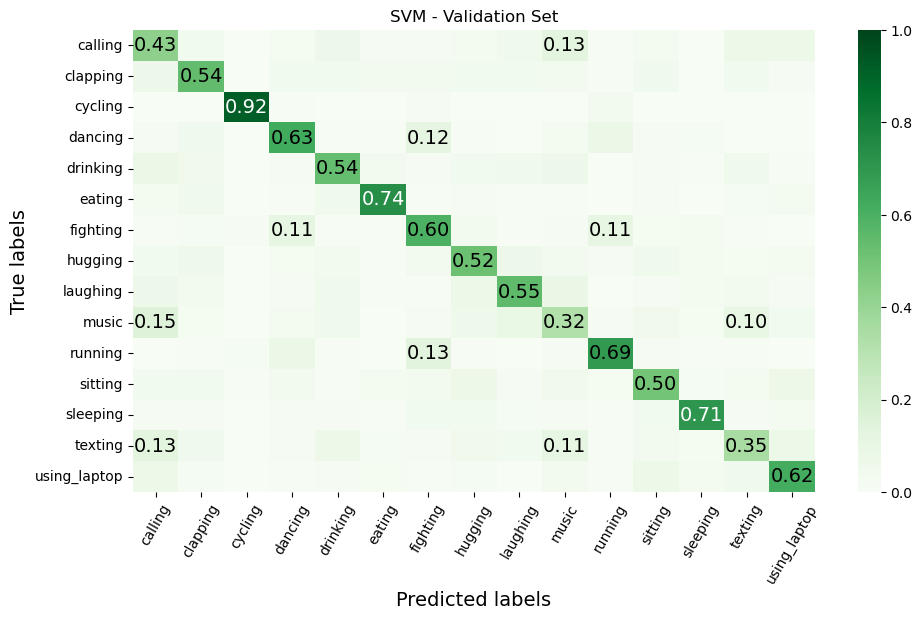

In [12]:
plot_confusion_matrix(conf_matrix)

In [13]:
def class_specific_metrics(cm, class_labels = labels):

    # Initialize dictionaries to hold metrics for each class
    accuracy = {}
    sensitivity = {}
    specificity = {}
    precision = {}

    for idx, label in enumerate(class_labels):
        # True positives
        TP = cm[idx, idx]

        # False positives
        FP = cm[:, idx].sum() - TP

        # False negatives
        FN = cm[idx, :].sum() - TP

        # True negatives
        TN = cm.sum() - (TP + FP + FN)

        # Calculate metrics
        accuracy[label] = (TP + TN) / cm.sum()
        sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision[label] = TP / (TP + FP) if (TP + FP) != 0 else 0

    metrics_dict = {label: {'Accuracy': accuracy[label],
                        'Sensitivity': sensitivity[label],
                        'Specificity': specificity[label],
                        'Precision': precision[label]}
                    for label in class_labels}

    # Convert the dictionary to a pandas DataFrame
    df_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df_metrics

    return df_metrics

In [14]:
val_metrics = class_specific_metrics(conf_matrix)
val_metrics

,Accuracy,Sensitivity,Specificity,Precision
calling,0.912143,0.428571,0.946684,0.364742
clapping,0.938413,0.539286,0.966922,0.538005
cycling,0.990238,0.920238,0.995238,0.932449
dancing,0.946270,0.626190,0.969133,0.591676
drinking,0.938492,0.535714,0.967262,0.538922
eating,0.968810,0.738095,0.985289,0.781841
fighting,0.938492,0.596429,0.962925,0.534685
hugging,0.933571,0.521429,0.963010,0.501718
laughing,0.941905,0.547619,0.970068,0.566502
music,0.911825,0.321429,0.953997,0.332922


### Test set

In [32]:
train_dataset, train_labels = create_dataset(train_df)

# Create a new instance of the model
model = SVC(kernel='rbf', C=10)

# Train the model
results = model.fit(train_dataset, train_labels)

In [33]:
test_dataset, test_labels = create_dataset(test_df)

# compute predicted labels
predicted_labels = model.predict(test_dataset)
    
# compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
    
# Evaluate the model
val_accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy:", round(val_accuracy,3))

Accuracy: 0.571


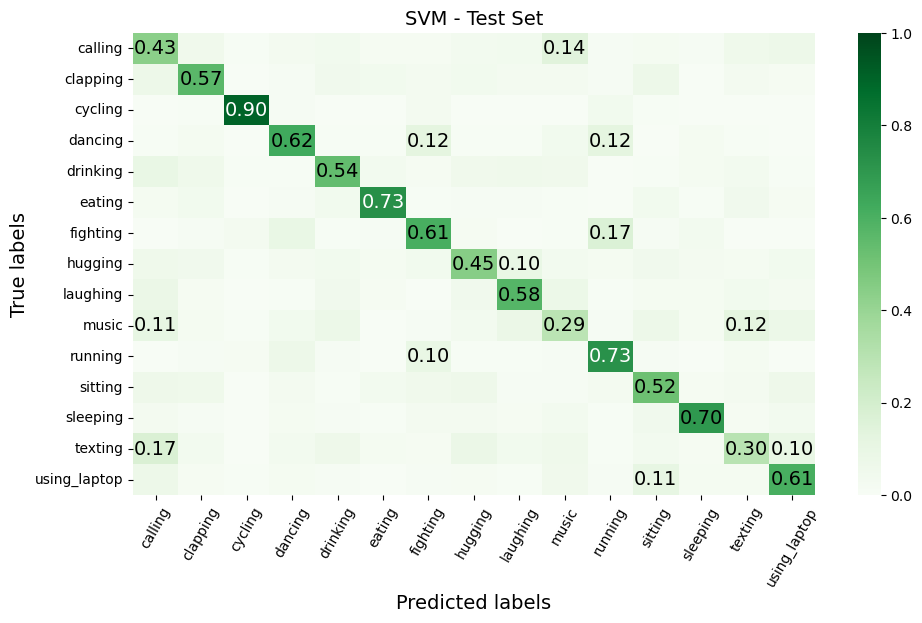

In [45]:
plot_confusion_matrix(cm, val=False, saveplot=True)

In [18]:
test_metrics = class_specific_metrics(cm)
test_metrics

,Accuracy,Sensitivity,Specificity,Precision
calling,0.909524,0.434524,0.943452,0.354369
clapping,0.942857,0.565476,0.969813,0.572289
cycling,0.988492,0.904762,0.994473,0.921212
dancing,0.946429,0.625000,0.969388,0.593220
drinking,0.941667,0.541667,0.970238,0.565217
eating,0.967460,0.732143,0.984269,0.768750
fighting,0.940873,0.607143,0.964711,0.551351
hugging,0.932540,0.446429,0.967262,0.493421
laughing,0.943651,0.577381,0.969813,0.577381
music,0.915079,0.291667,0.959609,0.340278


### Test on other APIs

In [53]:
# helper function

def fitSVM(file_name, use_kpoints=True, use_object=True):
    
    df = pd.read_pickle(data_directory + '/' + file_name + '.pkl')

    # apply the function to the dataframe
    df['keypoints'] = df['keypoints'].apply(lambda x: np.array(x))
    df['object'] = df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
    df['obj_vector'] = df['obj_vector'].apply(lambda x: np.array(x))
    df['category'] = df['category'].apply(lambda x: np.array(x))
    df['obj_input'] = df.apply(lambda x: np.sum(x['object']*x['obj_vector'], axis=0), axis=1)
    df['keypoints'] = df['keypoints'].apply(lambda x: x.flatten())
    
    print('Loaded dataset ', file_name)
    
    train_df, test_df = train_test_split_df(df, 0.2)

    train_dataset, train_labels = create_dataset(train_df, use_kpoints=use_kpoints, use_object=use_object)
    test_dataset, test_labels = create_dataset(test_df, use_kpoints=use_kpoints, use_object=use_object)

    # Create a new instance of the model
    model = SVC(kernel='rbf', C=10)

    # Train the model
    results = model.fit(train_dataset, train_labels)
    
    # compute predicted labels
    predicted_labels = model.predict(test_dataset)
    
    # compute the confusion matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    
    # Evaluate the model
    val_accuracy = accuracy_score(test_labels, predicted_labels)
    print("Accuracy:", round(val_accuracy,3))
    
    plot_confusion_matrix(cm, val=False)
    
    test_metrics = class_specific_metrics(cm)
    print(test_metrics)

    return cm

Loaded dataset  movenet_lightning_mobilenet_small
Accuracy: 0.549


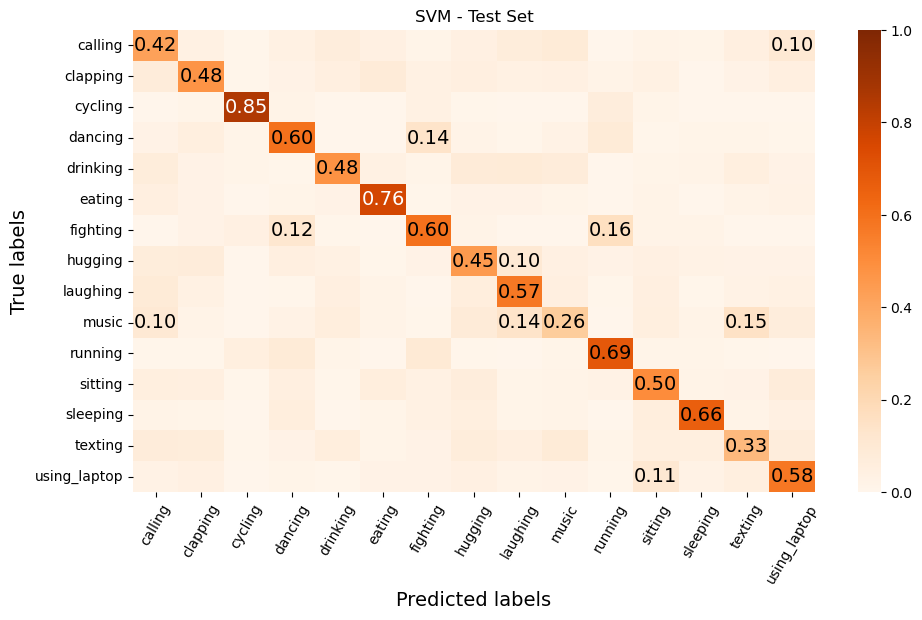

              Accuracy  Sensitivity  Specificity  Precision
calling       0.917063     0.422619     0.952381   0.387978
clapping      0.932937     0.476190     0.965561   0.496894
cycling       0.980556     0.851190     0.989796   0.856287
dancing       0.937698     0.595238     0.962160   0.529101
drinking      0.940873     0.482143     0.973639   0.566434
eating        0.963492     0.761905     0.977891   0.711111
fighting      0.940873     0.595238     0.965561   0.552486
hugging       0.922222     0.452381     0.955782   0.422222
laughing      0.934524     0.571429     0.960459   0.507937
music         0.917460     0.261905     0.964286   0.343750
running       0.951984     0.690476     0.970663   0.627027
sitting       0.933333     0.500000     0.964286   0.500000
sleeping      0.962302     0.660714     0.983844   0.744966
texting       0.925000     0.333333     0.967262   0.421053
using_laptop  0.937302     0.577381     0.963010   0.527174


In [20]:
fitSVM('movenet_lightning_mobilenet_small')

Loaded dataset  movenet_lightning_mobilenet_large
Accuracy: 0.562


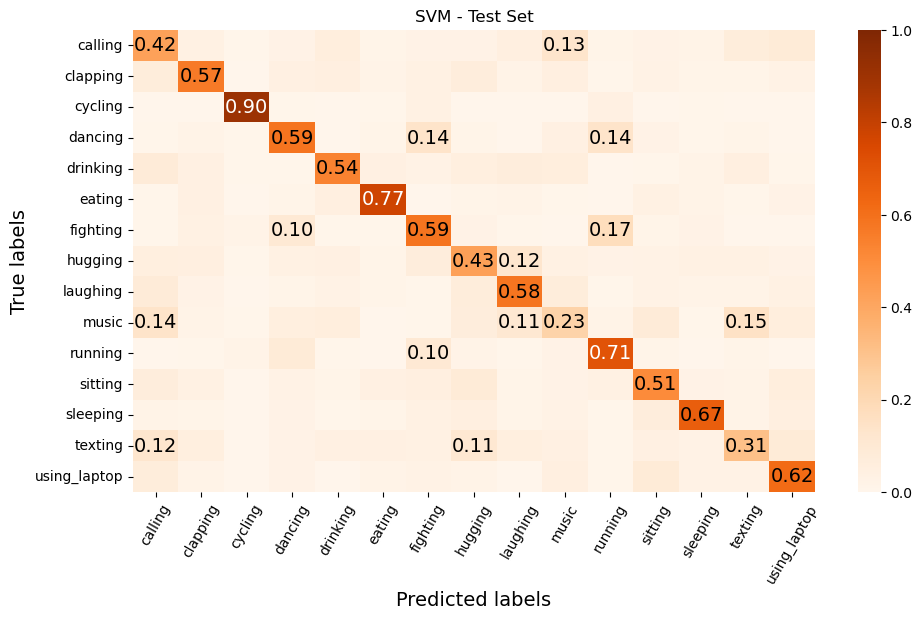

              Accuracy  Sensitivity  Specificity  Precision
calling       0.913095     0.422619     0.948129   0.367876
clapping      0.945238     0.565476     0.972364   0.593750
cycling       0.989286     0.904762     0.995323   0.932515
dancing       0.940476     0.589286     0.965561   0.550000
drinking      0.945238     0.535714     0.974490   0.600000
eating        0.969444     0.773810     0.983418   0.769231
fighting      0.933333     0.589286     0.957908   0.500000
hugging       0.921429     0.428571     0.956633   0.413793
laughing      0.940873     0.583333     0.966412   0.553672
music         0.911508     0.232143     0.960034   0.293233
running       0.949206     0.708333     0.966412   0.601010
sitting       0.934921     0.505952     0.965561   0.512048
sleeping      0.961508     0.666667     0.982568   0.732026
texting       0.925397     0.309524     0.969388   0.419355
using_laptop  0.943651     0.619048     0.966837   0.571429


In [21]:
fitSVM('movenet_lightning_mobilenet_large')

Loaded dataset  movenet_thunder_mobilenet_small
Accuracy: 0.552


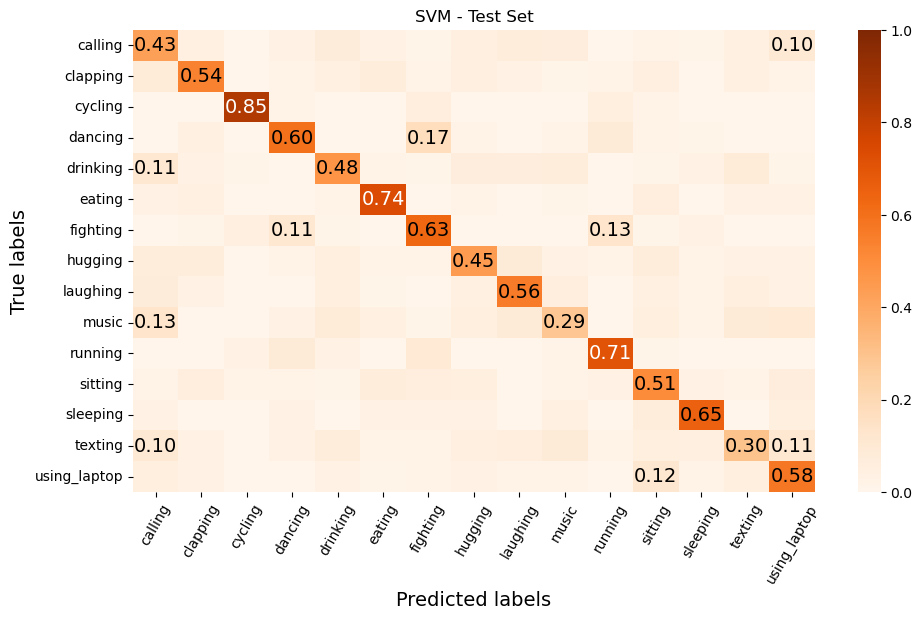

              Accuracy  Sensitivity  Specificity  Precision
calling       0.914286     0.428571     0.948980   0.375000
clapping      0.941667     0.535714     0.970663   0.566038
cycling       0.980952     0.845238     0.990646   0.865854
dancing       0.944048     0.595238     0.968963   0.578035
drinking      0.932540     0.476190     0.965136   0.493827
eating        0.959524     0.738095     0.975340   0.681319
fighting      0.938889     0.630952     0.960884   0.535354
hugging       0.931746     0.446429     0.966412   0.487013
laughing      0.941667     0.559524     0.968963   0.562874
music         0.921032     0.285714     0.966412   0.377953
running       0.954762     0.708333     0.972364   0.646739
sitting       0.926190     0.505952     0.956207   0.452128
sleeping      0.960714     0.654762     0.982568   0.728477
texting       0.921429     0.297619     0.965986   0.384615
using_laptop  0.935317     0.577381     0.960884   0.513228


In [22]:
fitSVM('movenet_thunder_mobilenet_small')

Loaded dataset  movenet_thunder_mobilenet_large
Accuracy: 0.571


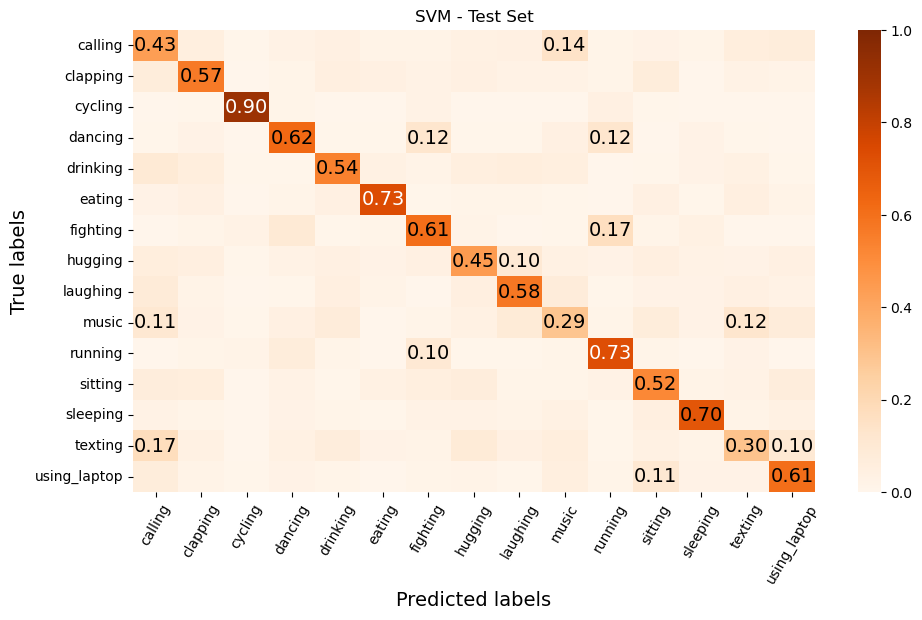

              Accuracy  Sensitivity  Specificity  Precision
calling       0.909524     0.434524     0.943452   0.354369
clapping      0.942857     0.565476     0.969813   0.572289
cycling       0.988492     0.904762     0.994473   0.921212
dancing       0.946429     0.625000     0.969388   0.593220
drinking      0.941667     0.541667     0.970238   0.565217
eating        0.967460     0.732143     0.984269   0.768750
fighting      0.940873     0.607143     0.964711   0.551351
hugging       0.932540     0.446429     0.967262   0.493421
laughing      0.943651     0.577381     0.969813   0.577381
music         0.915079     0.291667     0.959609   0.340278
running       0.951587     0.726190     0.967687   0.616162
sitting       0.933730     0.517857     0.963435   0.502890
sleeping      0.963889     0.696429     0.982993   0.745223
texting       0.922222     0.297619     0.966837   0.390625
using_laptop  0.942857     0.607143     0.966837   0.566667


In [23]:
fitSVM('movenet_thunder_mobilenet_large')

Loaded dataset  movenet_thunder_mobilenet_large
Accuracy: 0.448


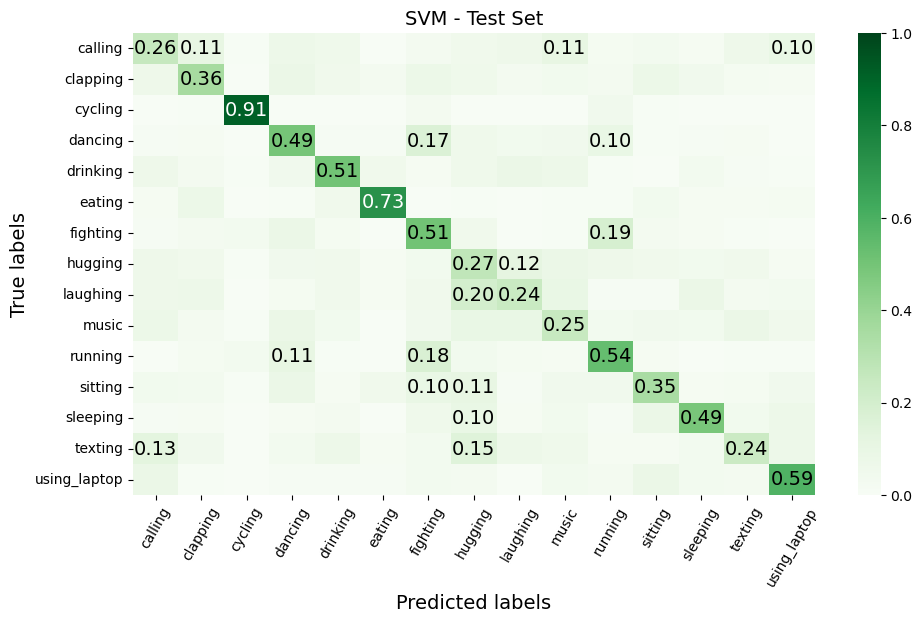

              Accuracy  Sensitivity  Specificity  Precision
calling       0.907143     0.255952     0.953656   0.282895
clapping      0.920238     0.357143     0.960459   0.392157
cycling       0.987302     0.910714     0.992772   0.900000
dancing       0.917857     0.494048     0.948129   0.404878
drinking      0.934524     0.505952     0.965136   0.508982
eating        0.967460     0.726190     0.984694   0.772152
fighting      0.908730     0.505952     0.937500   0.366379
hugging       0.883730     0.273810     0.927296   0.211982
laughing      0.912302     0.244048     0.960034   0.303704
music         0.905159     0.250000     0.951956   0.270968
running       0.927381     0.535714     0.955357   0.461538
sitting       0.922222     0.351190     0.963010   0.404110
sleeping      0.938889     0.488095     0.971088   0.546667
texting       0.921429     0.238095     0.970238   0.363636
using_laptop  0.942460     0.589286     0.967687   0.565714
Loaded dataset  movenet_lightning_mobile

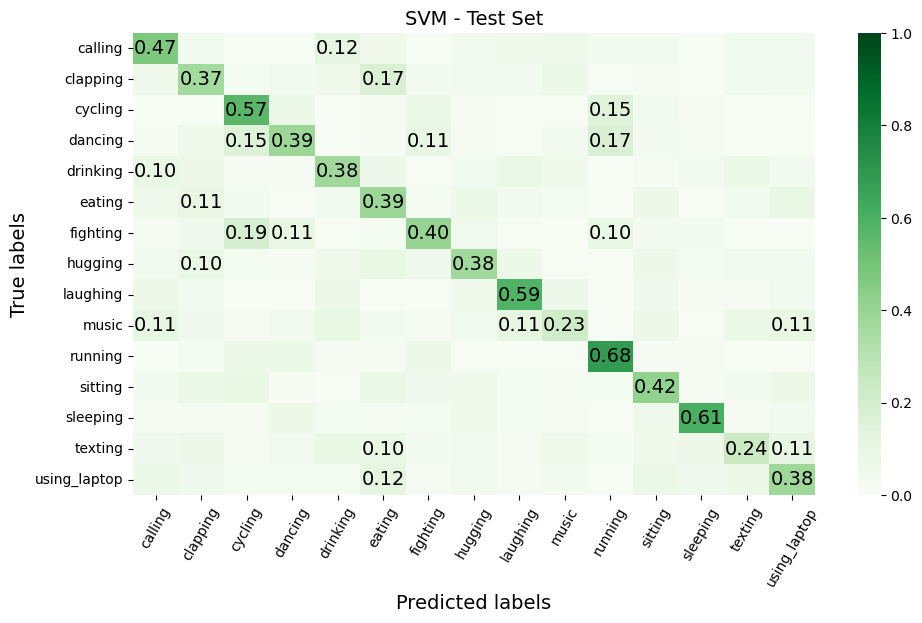

              Accuracy  Sensitivity  Specificity  Precision
calling       0.922222     0.470238     0.954507   0.424731
clapping      0.908333     0.369048     0.946854   0.331551
cycling       0.925397     0.565476     0.951105   0.452381
dancing       0.923016     0.386905     0.961310   0.416667
drinking      0.919048     0.375000     0.957908   0.388889
eating        0.904762     0.386905     0.941752   0.321782
fighting      0.926984     0.404762     0.964286   0.447368
hugging       0.921429     0.375000     0.960459   0.403846
laughing      0.940079     0.589286     0.965136   0.546961
music         0.918651     0.226190     0.968112   0.336283
running       0.944048     0.684524     0.962585   0.566502
sitting       0.919444     0.416667     0.955357   0.400000
sleeping      0.954365     0.607143     0.979167   0.675497
texting       0.918651     0.238095     0.967262   0.341880
using_laptop  0.917063     0.380952     0.955357   0.378698
Loaded dataset  movenet_thunder_mobilene

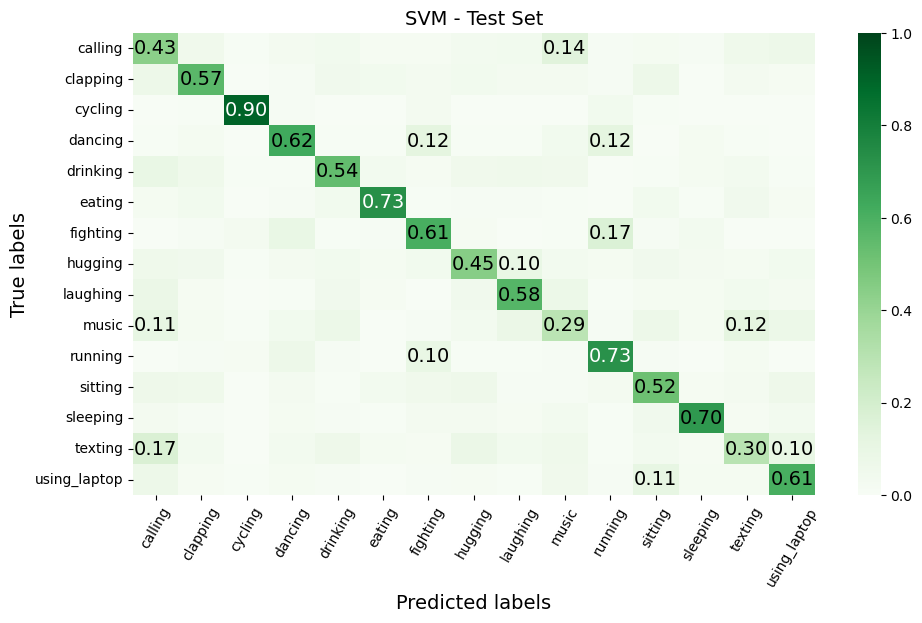

              Accuracy  Sensitivity  Specificity  Precision
calling       0.909524     0.434524     0.943452   0.354369
clapping      0.942857     0.565476     0.969813   0.572289
cycling       0.988492     0.904762     0.994473   0.921212
dancing       0.946429     0.625000     0.969388   0.593220
drinking      0.941667     0.541667     0.970238   0.565217
eating        0.967460     0.732143     0.984269   0.768750
fighting      0.940873     0.607143     0.964711   0.551351
hugging       0.932540     0.446429     0.967262   0.493421
laughing      0.943651     0.577381     0.969813   0.577381
music         0.915079     0.291667     0.959609   0.340278
running       0.951587     0.726190     0.967687   0.616162
sitting       0.933730     0.517857     0.963435   0.502890
sleeping      0.963889     0.696429     0.982993   0.745223
texting       0.922222     0.297619     0.966837   0.390625
using_laptop  0.942857     0.607143     0.966837   0.566667


In [54]:
cm_th_lg_nokp = fitSVM('movenet_thunder_mobilenet_large', use_kpoints=False)
cm_th_lg_nobj = fitSVM('movenet_lightning_mobilenet_large', use_object=False)
cm_th_lg = fitSVM('movenet_thunder_mobilenet_large')

In [55]:
def plot_confusion_matrix_difference(cm1, cm2, threshold=0.1):
    #normalize cm
    cm_normalized = (cm1.astype('float')-cm2.astype('float'))/ cm1.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(11, 6))
    ax = sns.heatmap(cm_normalized, annot=False, vmin=-0.5, vmax=0.5, cbar=True, xticklabels=labels, yticklabels=labels, 
                     cmap='coolwarm')
    
    # Annotate only the main diagonal with rounded values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == j or np.abs(cm_normalized[i, j]) > threshold:
                if cm_normalized[i, j] < 0.7:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='black', fontsize=14)
                else:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='white', fontsize=14)    
                
    # Labels, title and axes
    ax.set_title("Neural Network")
    ax.set_xlabel('Predicted labels', fontsize = 14)
    ax.set_ylabel('True labels', fontsize = 14)
    plt.xticks(rotation=60)
    
    plt.show()

    # return the diagonal of the confusion matrix
    return np.diag(cm_normalized)

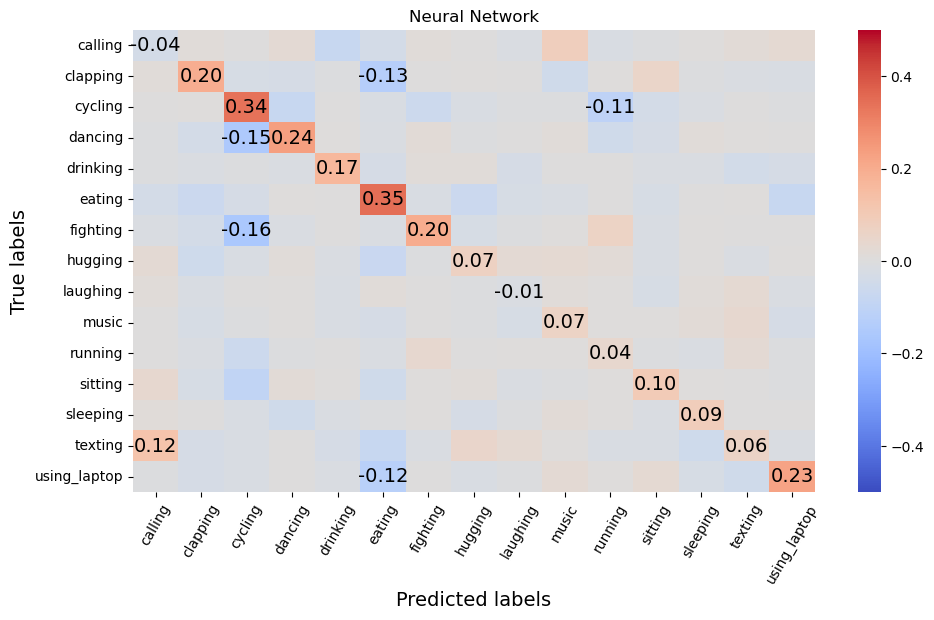

In [56]:
diag_base_nobj = plot_confusion_matrix_difference(cm_th_lg, cm_th_lg_nobj)

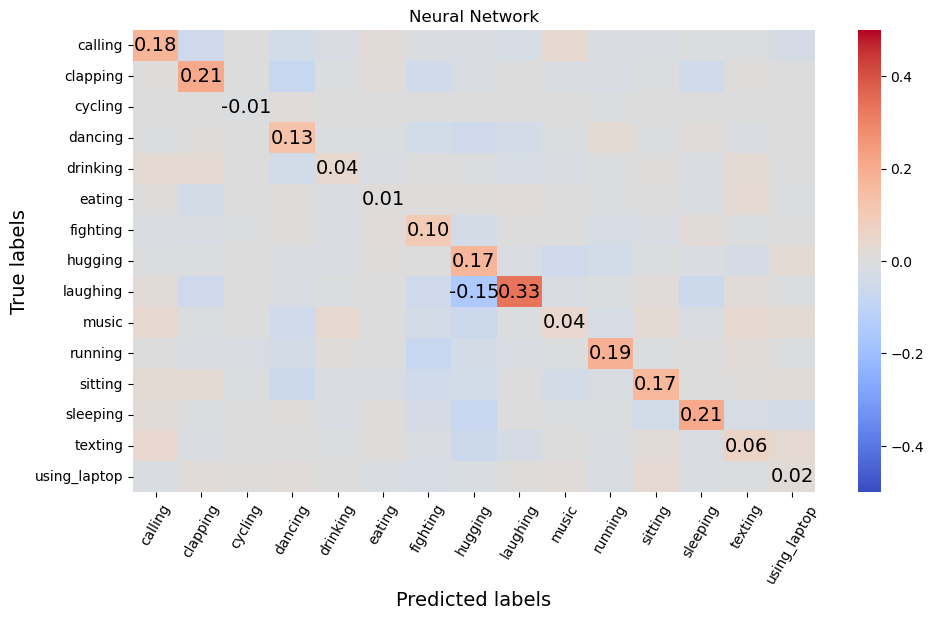

In [57]:
diag_base_nokp = plot_confusion_matrix_difference(cm_th_lg, cm_th_lg_nokp)

In [84]:
# plot the diagonal of the confusion matrix flattened but with the same colormap and format
def plot_diagonal(diagonal_values, labels, title, saveplot=False):
    # Step 1: Convert the diagonal values to a numpy array
    diagonal_values = np.array(diagonal_values)

    cm_diagonal = np.array([diagonal_values])

    plt.figure(figsize=(11, 1)) 
    ax = sns.heatmap(cm_diagonal, annot=True, vmin=-0.4, vmax=0.4, cbar=False, 
                     cmap='coolwarm', xticklabels=labels, yticklabels=[], annot_kws={"size": 14}, fmt=".2f") 

    #ax.set_title(title, fontsize=14)
    plt.xticks(rotation=60, fontsize=12)
    
    if saveplot:
        plt.savefig(data_directory + '/' + title + '2.pdf', format='pdf', bbox_inches='tight')

    plt.show()

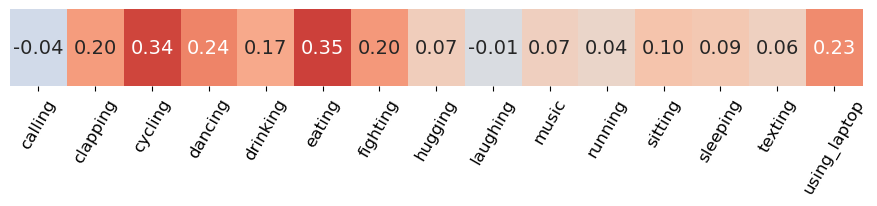

In [85]:
plot_diagonal(diag_base_nobj, labels, title='Effect of adding Object features',saveplot=True)

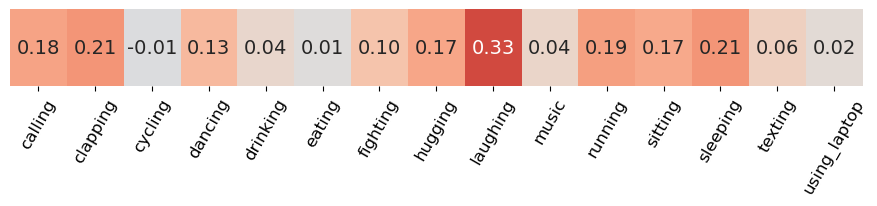

In [86]:
plot_diagonal(diag_base_nokp, labels, title='Effect of adding Keypoints features',saveplot=True)